# **Predicción del win rate**

En este notebook utilizaremos una base de datos adicional a la propuesta en la descripción del problema. En este caso usaremos la base de datos disponible en https://www.kaggle.com/datasets/gaborfodor/hearthstone-decks, la cual cuenta con el winrate de mazos que han sido utilizados en un mínimo de 1000 partidas, de manera que nos entrega una herramienta muy útil para la predicción del mismo.

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import sklearn
import warnings
import pickle

from tensorflow import keras
from tensorflow.keras import layers
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import OneHotEncoder

## Predicción de winrate

En esta sección adaptamos un random forest para predecir el win rate de mazos, lo cuál será necesario para la comparación en la calidad de los mazos recomendados.

### BDD win rate
A continuación cargamos la base de datos que usaremos para estimar el win rate

In [16]:
data = pd.read_csv("data/top_hearthstone_decks_20200221.csv")
data["wr"] = data["wr"]*100
data.describe()

,dust,wr,games,duration,wins
count,736.000000,736.000000,736.000000,736.000000,736.000000
mean,10952.608696,54.141848,5912.092391,7.989402,3285.078940
std,5012.298316,3.547108,17250.587780,1.649571,9865.974255
min,1300.000000,37.100000,1000.000000,4.900000,459.800000
25%,6695.000000,52.900000,1400.000000,6.700000,739.375000
50%,10660.000000,55.000000,2400.000000,8.050000,1297.750000
75%,14935.000000,56.600000,4625.000000,9.000000,2527.650000
max,21280.000000,60.200000,350000.000000,13.500000,201250.000000


In [17]:
data.head()

,type,dust,wr,games,duration,card_0,card_1,card_2,card_3,card_4,...,card_22,card_23,card_24,card_25,card_26,card_27,card_28,card_29,wins,hero
0,Resurrect Priest,9840,60.2,1100,11.0,Forbidden Words,Penance,Bad Luck Albatross,Breath of the Infinite,Grave Rune,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,662.2,Priest
1,Dragon Hunter,5280,59.8,43000,5.6,Blazing Battlemage,Dwarven Sharpshooter,Tracking,Corrosive Breath,Faerie Dragon,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,25714.0,Hunter
2,Highlander Hunter,15600,59.3,1800,7.2,Blazing Battlemage,Crystallizer,Dwarven Sharpshooter,Springpaw,Tracking,...,Dragonmaw Poacher,Houndmaster Shaw,Faceless Corruptor,Zilliax,Veranus,Dinotamer Brann,Siamat,Dragonqueen Alexstrasza,1067.4,Hunter
3,Dragon Hunter,5340,59.1,3000,5.8,Blazing Battlemage,Dwarven Sharpshooter,Tracking,Corrosive Breath,Faerie Dragon,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1773.0,Hunter
4,Mech Paladin,6240,58.9,1100,5.5,Blessing of Wisdom,Crystology,Glow-Tron,Hot Air Balloon,Mecharoo,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,647.9,Paladin


### BDD original del proyecto

In [18]:
url = 'data/data.csv'
data_for_rec = pd.read_csv(url)
data_for_rec.head()

,craft_cost,date,deck_archetype,deck_class,deck_format,deck_id,deck_set,deck_type,rating,title,...,card_20,card_21,card_22,card_23,card_24,card_25,card_26,card_27,card_28,card_29
0,9740,2016-02-19,Unknown,Priest,W,433004,Explorers,Tavern Brawl,1,Reno Priest,...,374,2280,2511,2555,2566,2582,2683,2736,2568,2883
1,9840,2016-02-19,Unknown,Warrior,W,433003,Explorers,Ranked Deck,1,RoosterWarrior,...,1781,1781,2021,2021,2064,2064,2078,2510,2729,2736
2,2600,2016-02-19,Unknown,Mage,W,433002,Explorers,Theorycraft,1,Annoying,...,1793,1801,1801,2037,2037,2064,2064,2078,38710,38710
3,15600,2016-02-19,Unknown,Warrior,W,433001,Explorers,NaN,0,Standart pay to win warrior,...,1657,1721,2018,2296,2262,336,2729,2729,2736,2760
4,7700,2016-02-19,Unknown,Paladin,W,432997,Explorers,Ranked Deck,1,Palamix,...,2027,2029,2029,2064,2078,374,2717,2717,2889,2889


In [5]:
data_for_rec[data_for_rec["rating"]>=10]

,craft_cost,date,deck_archetype,deck_class,deck_format,deck_id,deck_set,deck_type,rating,title,...,card_20,card_21,card_22,card_23,card_24,card_25,card_26,card_27,card_28,card_29
121,4320,2016-02-19,Unknown,Druid,W,432795,Explorers,Ranked Deck,20,Cereza's Midrange Druid - European Winter Prel...,...,1784,1914,2064,2064,2078,2262,2792,2792,38319,38319
137,8120,2016-02-19,Miracle Rogue,Rogue,S,432773,Explorers,Ranked Deck,303,Standard Miracle Rogue,...,1117,1158,1158,268,268,1651,2884,2884,38403,38578
145,2640,2016-02-19,Unknown,Druid,W,432750,Explorers,Ranked Deck,42,F2P Mech Druid To LEGEND w/ gameplay & guide,...,2053,2053,2064,2064,2070,2070,2782,2782,2792,2792
261,4200,2016-02-18,Unknown,Warlock,W,432518,Explorers,Ranked Deck,118,[S23+24 Legend EU] Cycle Zoo,...,2013,2078,2093,2093,2288,2288,2724,2895,2895,2949
262,1100,2016-02-18,Unknown,Hunter,W,432517,Explorers,Ranked Deck,71,69.6% winrate hybrid hunter,...,1783,1783,2011,2011,2064,2064,2260,2260,2490,2641
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
346138,6060,2015-04-01,Unknown,Mage,W,218088,Undertaker Nerf,Ranked Deck,35,Echo of Medivh HEALER mage INSANE FUN AND EFFE...,...,1941,2037,2037,2042,2044,2044,2057,2057,2078,2262
346143,13680,2014-05-03,Unknown,Druid,W,50395,Live Patch 5170,NaN,82,Team Five,...,2279,2500,2509,2511,2521,2683,2910,2925,38526,38669
346147,8240,2014-05-03,Unknown,Mage,S,50427,Live Patch 5170,Ranked Deck,20,The new Mage !,...,790,790,825,825,906,1004,1004,1080,1087,374
346203,6640,2016-12-07,Pirate Rogue,Rogue,S,697067,Gadgetzan,Ranked Deck,35,Rufeng's #1 China Legend Pirate Rogue (27-1),...,2490,2490,2715,2715,2767,39698,39698,40465,40608,40608


In [19]:
import json
url = 'data/refs.json'
with open(url, 'r', encoding='utf-8') as file:
    data_dict = json.load(file)
# cantidad de cartas
print(len(data_dict))
data_dict[5]

3117


{'cardClass': 'NEUTRAL',
 'cost': 2,
 'dbfId': 19292,
 'id': 'LOEA15_2',
 'name': 'Unstable Portal',
 'playerClass': 'NEUTRAL',
 'set': 'LOE',
 'text': '<b>Hero Power</b>\nAdd a random minion to your hand. It costs (3) less.',
 'type': 'HERO_POWER'}

Ahora combinamos las cartas disponibles en ambas bases de datos para transformar las cartas en una variable numérica:

In [20]:
data_dict_total_cards = []
for i in range(len(data_dict)):
  if data_dict[i]['id']!='PlaceholderCard':
    data_dict_total_cards.append(data_dict[i]['name'])
data_dict_total_cards = set(data_dict_total_cards)
print(len(data_dict_total_cards))

2460


In [21]:
total_cards1 = []
for i in range(30):
  total_cards1.append(data[f'card_{i}'].unique())
total_cards2 = set(total_cards1[0])
for i in range(1,30):
  diff = set(total_cards1[i])-total_cards2
  total_cards2 = total_cards2.union(diff)
print(f'totalcards2 = ',len(total_cards2))

totalcards2 =  672


In [22]:
total_cards = list(data_dict_total_cards.union(total_cards2))
print(len(total_cards))

2952


In [23]:
name_to_position = {name: idx for idx, name in enumerate(total_cards)}
for i in range(30):
  data[f'card_{i}'] = data[f'card_{i}'].map(name_to_position)
  data[f'card_{i}'] = data[f'card_{i}'].fillna(-1).astype(int)

In [13]:
data.head()
X_num = data.drop(columns=["wr","games","duration","type","wins","hero"])
X_cat = pd.DataFrame(data["hero"])
Y = data["wr"]

encoder = OneHotEncoder(sparse_output=False, drop=None) 
encoded_categorical = encoder.fit_transform(X_cat)
encoded_df = pd.DataFrame(encoded_categorical, columns=encoder.get_feature_names_out(X_cat.columns))
final_df = pd.concat([X_num, encoded_df], axis=1)
print(final_df)

X_train, X_test, Y_train, Y_test = train_test_split(final_df, Y, test_size = 0.3, random_state = 42)
rf = RandomForestRegressor(n_estimators = 150, max_features = 'sqrt', max_depth = 40, random_state = 18).fit(X_train, Y_train)

      dust  card_0  card_1  card_2  card_3  card_4  card_5  card_6  card_7  \
0     9840    1929    2430    1303    2600     222     525    2061    1363   
1     5280    1148    1088    1835    2023    2214    2013    1168     709   
2    15600    1148    2917    1088     412    1835    2214    1168    2711   
3     5340    1148    1088    1835    2023    2214    2013    1168     709   
4     6240      81     942    1729    1549    1394    2919    1102    2126   
..     ...     ...     ...     ...     ...     ...     ...     ...     ...   
731   9800    1784    2344     448     897     722    1253    2600    1193   
732  17300    1512    1586     657    2221      88    2466    2350     396   
733  15200    1013    1414    2278    1604    1593     880     846    1598   
734   6440    1512    1586     657    2221     378     280    2350     396   
735   9640      88     893    1158     396     919    2190    1870     773   

     card_8  ...  card_29  hero_Druid  hero_Hunter  hero_Mage  

In [ ]:
with open("encoder", "wb") as f:
    pickle.dump(encoder, f)

NameError: name 'encoder' is not defined

In [13]:
X_train.shape

(515, 40)

In [14]:
prediction = rf.predict(X_test)

In [15]:
from sklearn.metrics import mean_squared_error, r2_score
mse = mean_squared_error(Y_test, prediction)
rmse = mse**.5
print(mse)
print(rmse)

6.717061173613324
2.5917293789308564


In [16]:
import pickle

# Save the model
with open("win_rate_RF.pkl", "wb") as f:
    pickle.dump(rf, f)

### Pedir predicción de un mazo cualquiera

In [ ]:
mazo_gen_num = data_for_rec.drop(columns=['date', 'deck_archetype', 'deck_class', 'deck_format',
       'deck_id', 'deck_set', 'deck_type', 'rating', 'title', 'user']).iloc[125].to_frame().transpose().reset_index()
mazo_gen_cat = pd.DataFrame(data_for_rec["deck_class"]).iloc[125].to_frame()
encoded_categorical = encoder.transform(mazo_gen_cat)
encoded_df = pd.DataFrame(encoded_categorical, columns=encoder.get_feature_names_out())
final_df = pd.concat([mazo_gen_num, encoded_df], axis=1).drop(columns=["index"]).rename(columns={"craft_cost":"dust"})
final_df
rf.predict(final_df)

c:\Users\gusco\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but OneHotEncoder was fitted with feature names
  warnings.warn(


array([51.81033333])

In [ ]:
mazo_gen_num = data_for_rec.drop(columns=['date', 'deck_archetype', 'deck_class', 'deck_format',
       'deck_id', 'deck_set', 'deck_type', 'rating', 'title', 'user']).reset_index()
mazo_gen_cat = pd.DataFrame(data_for_rec["deck_class"]).rename(columns={"deck_class":"hero"})
encoded_categorical = encoder.transform(mazo_gen_cat)
encoded_df = pd.DataFrame(encoded_categorical, columns=encoder.get_feature_names_out())
final_df = pd.concat([mazo_gen_num, encoded_df], axis=1).drop(columns=["index"]).rename(columns={"craft_cost":"dust"})
final_df
results = rf.predict(final_df)

In [19]:
print(np.mean(results),np.max(results),np.min(results))

51.850054636174754 56.049999999999976 47.37666666666662


## NNv1

In [10]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
import numpy as np
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import Huber
data.head()
X_num = data.drop(columns=["wr","games","duration","type","wins","hero"])
X_cat = pd.DataFrame(data["hero"])
Y = data["wr"]

encoder = OneHotEncoder(sparse_output=False, drop=None)
encoded_categorical = encoder.fit_transform(X_cat)
encoded_df = pd.DataFrame(encoded_categorical, columns=encoder.get_feature_names_out(X_cat.columns))
final_df = pd.concat([X_num, encoded_df], axis=1)
print(final_df)

X_train, X_test, y_train, y_test = train_test_split(final_df, Y, test_size=0.2, random_state=42)
model = keras.Sequential([
    layers.Input(shape=(40,)),
    layers.Dense(64, activation='relu'), 
    layers.Dense(128, activation='tanh'),  
    layers.GaussianDropout(0.3),  
    layers.Dense(64, activation='relu'), 
    layers.Dense(32, activation='linear'),
    layers.GaussianDropout(0.1), 
    layers.Dense(64, activation='relu'),
    layers.Dense(1, activation='linear') 
])
huber_loss = Huber(delta=1.0)
model.compile(optimizer=Adam(learning_rate=0.0001), loss=huber_loss) 

history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test))
# test_loss = model.evaluate(X_test, y_test)
# print(f"Test Loss: {test_loss:.4f}")

      dust  card_0  card_1  card_2  card_3  card_4  card_5  card_6  card_7  \
0     9840    1901    1270    1423     119    2000    1755    1393    1441   
1     5280     589      21    1654     817     317    2908     902    1935   
2    15600     589    1761      21    2808    1654     317     902    2312   
3     5340     589      21    1654     817     317    2908     902    1935   
4     6240    1622    1593     263    2440     128    2711    2145    2641   
..     ...     ...     ...     ...     ...     ...     ...     ...     ...   
731   9800     504    2191    1175     573    1721     576     119    2586   
732  17300    1659    2513    2317    1340    2225     397     580     182   
733  15200    2204    1155    1446    2169     803    2232    1223    1688   
734   6440    1659    2513    2317    1340    1493     161     580     182   
735   9640    2225      72     747     182    2613    2445    2527      42   

     card_8  ...  card_29  hero_Druid  hero_Hunter  hero_Mage  

In [64]:
model.save("win_rate_NNv1.keras")

In [ ]:
model = keras.models.load_model("win_rate_NN.keras")
#model.summary()

with open("Entrega 2/encoder", "rb") as f:
    encoder = pickle.load(f)
with open("win_rate_RF.pkl", "rb") as f:
    rf = pickle.load(f)

In [61]:
poor_wr = []
medium_wr = []
good_wr = []
for i in range(50):
    subdata = data[data['wr']<=48]
    mazo_gen_num = subdata.iloc[i][[f'card_{j}' for j in range(30)]] #if i!=np.int64(2836) else np.random.sample(total_cards2)
    mazo_gen_num  = pd.DataFrame(mazo_gen_num).transpose().reset_index().drop(columns=["index"])
    mazo_gen_num
    mazo_gen_cat1 = pd.DataFrame([{"hero":data.iloc[i]['hero']}])
    mazo_gen_cat2 = pd.DataFrame([{"craft_cost":subdata.iloc[i]['dust']}])
    encoded_categorical = encoder.transform(mazo_gen_cat1)
    encoded_df = pd.DataFrame(encoded_categorical, columns=encoder.get_feature_names_out())
    final_df = pd.concat([mazo_gen_cat2,mazo_gen_num, encoded_df], axis=1).rename(columns={"craft_cost":"dust"})
    poor_wr.append(model.predict(final_df,verbose=None)[0][0])
    subdata = data[data['wr']<=52]
    subdata = subdata[subdata['wr']>48]
    mazo_gen_num = subdata.iloc[i][[f'card_{j}' for j in range(30)]] #if i!=np.int64(2836) else np.random.sample(total_cards2)
    mazo_gen_num  = pd.DataFrame(mazo_gen_num).transpose().reset_index().drop(columns=["index"])
    mazo_gen_num
    mazo_gen_cat1 = pd.DataFrame([{"hero":subdata.iloc[i]['hero']}])
    mazo_gen_cat2 = pd.DataFrame([{"craft_cost":subdata.iloc[i]['dust']}])
    encoded_categorical = encoder.transform(mazo_gen_cat1)
    encoded_df = pd.DataFrame(encoded_categorical, columns=encoder.get_feature_names_out())
    final_df = pd.concat([mazo_gen_cat2,mazo_gen_num, encoded_df], axis=1).rename(columns={"craft_cost":"dust"})
    medium_wr.append(model.predict(final_df,verbose=None)[0][0])
    subdata = data[data['wr']>52]
    mazo_gen_num = subdata.iloc[i][[f'card_{j}' for j in range(30)]] #if i!=np.int64(2836) else np.random.sample(total_cards2)
    mazo_gen_num  = pd.DataFrame(mazo_gen_num).transpose().reset_index().drop(columns=["index"])
    mazo_gen_num
    mazo_gen_cat1 = pd.DataFrame([{"hero":subdata.iloc[i]['hero']}])
    mazo_gen_cat2 = pd.DataFrame([{"craft_cost":subdata.iloc[i]['dust']}])
    encoded_categorical = encoder.transform(mazo_gen_cat1)
    encoded_df = pd.DataFrame(encoded_categorical, columns=encoder.get_feature_names_out())
    final_df = pd.concat([mazo_gen_cat2,mazo_gen_num, encoded_df], axis=1).rename(columns={"craft_cost":"dust"})
    good_wr.append(model.predict(final_df,verbose=None)[0][0])

In [62]:
wr_pred = pd.DataFrame({"bad":poor_wr,"mid":medium_wr,"good":good_wr})

In [63]:
wr_pred.describe()

,bad,mid,good
count,50.000000,50.000000,50.000000
mean,52.183407,52.242298,53.382668
std,1.307413,0.876377,1.225436
min,47.588024,50.268192,50.810627
25%,51.459998,51.853436,52.526731
50%,52.395529,52.312340,53.593790
75%,52.960651,52.856417,54.259070
max,55.440533,54.211201,55.390556


## NNv2

In [11]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
import numpy as np
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import Huber
data.head()
X_num = data.drop(columns=["wr","games","duration","type","wins","hero"])
X_cat = pd.DataFrame(data["hero"])
Y = data["wr"]

encoder = OneHotEncoder(sparse_output=False, drop=None)
encoded_categorical = encoder.fit_transform(X_cat)
encoded_df = pd.DataFrame(encoded_categorical, columns=encoder.get_feature_names_out(X_cat.columns))
final_df = pd.concat([X_num, encoded_df], axis=1)
print(final_df)

X_train, X_test, y_train, y_test = train_test_split(final_df, Y, test_size=0.2, random_state=42)
model = keras.Sequential([
    layers.Input(shape=(40,)),
    layers.Dense(64, activation='relu'), 
    layers.Dense(128, activation='tanh'),  
    layers.GaussianDropout(0.2),  
    layers.Dense(64, activation='relu'), 
    layers.GaussianDropout(0.2), 
    layers.Dense(32, activation='relu'),
    layers.Dense(1, activation='linear') 
])
huber_loss = Huber(delta=1.0)
model.compile(optimizer=Adam(learning_rate=0.0001), loss=huber_loss) 

history2 = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test))
# test_loss = model.evaluate(X_test, y_test)
# print(f"Test Loss: {test_loss:.4f}")

      dust  card_0  card_1  card_2  card_3  card_4  card_5  card_6  card_7  \
0     9840    1901    1270    1423     119    2000    1755    1393    1441   
1     5280     589      21    1654     817     317    2908     902    1935   
2    15600     589    1761      21    2808    1654     317     902    2312   
3     5340     589      21    1654     817     317    2908     902    1935   
4     6240    1622    1593     263    2440     128    2711    2145    2641   
..     ...     ...     ...     ...     ...     ...     ...     ...     ...   
731   9800     504    2191    1175     573    1721     576     119    2586   
732  17300    1659    2513    2317    1340    2225     397     580     182   
733  15200    2204    1155    1446    2169     803    2232    1223    1688   
734   6440    1659    2513    2317    1340    1493     161     580     182   
735   9640    2225      72     747     182    2613    2445    2527      42   

     card_8  ...  card_29  hero_Druid  hero_Hunter  hero_Mage  

In [ ]:
model.save("win_rate_NNv2.keras")

In [24]:
model = keras.models.load_model("win_rate_NNv2.keras")

In [40]:
poor_wr = []
medium_wr = []
good_wr = []
model = keras.models.load_model("win_rate_NNv3.keras")
for i in range(50):
    subdata = data[data['wr']<=48]
    mazo_gen_num = subdata.iloc[i][[f'card_{j}' for j in range(30)]] #if i!=np.int64(2836) else np.random.sample(total_cards2)
    mazo_gen_num  = pd.DataFrame(mazo_gen_num).transpose().reset_index().drop(columns=["index"])
    mazo_gen_num
    mazo_gen_cat1 = pd.DataFrame([{"hero":data.iloc[i]['hero']}])
    mazo_gen_cat2 = pd.DataFrame([{"craft_cost":subdata.iloc[i]['dust']}])
    encoded_categorical = encoder.transform(mazo_gen_cat1)
    encoded_df = pd.DataFrame(encoded_categorical, columns=encoder.get_feature_names_out())
    final_df = pd.concat([mazo_gen_cat2,mazo_gen_num, encoded_df], axis=1).rename(columns={"craft_cost":"dust"})
    poor_wr.append(model.predict(final_df,verbose=None)[0][0])
    subdata = data[data['wr']<=52]
    subdata = subdata[subdata['wr']>48]
    mazo_gen_num = subdata.iloc[i][[f'card_{j}' for j in range(30)]] #if i!=np.int64(2836) else np.random.sample(total_cards2)
    mazo_gen_num  = pd.DataFrame(mazo_gen_num).transpose().reset_index().drop(columns=["index"])
    mazo_gen_num
    mazo_gen_cat1 = pd.DataFrame([{"hero":subdata.iloc[i]['hero']}])
    mazo_gen_cat2 = pd.DataFrame([{"craft_cost":subdata.iloc[i]['dust']}])
    encoded_categorical = encoder.transform(mazo_gen_cat1)
    encoded_df = pd.DataFrame(encoded_categorical, columns=encoder.get_feature_names_out())
    final_df = pd.concat([mazo_gen_cat2,mazo_gen_num, encoded_df], axis=1).rename(columns={"craft_cost":"dust"})
    medium_wr.append(model.predict(final_df,verbose=None)[0][0])
    subdata = data[data['wr']>52]
    mazo_gen_num = subdata.iloc[i][[f'card_{j}' for j in range(30)]] #if i!=np.int64(2836) else np.random.sample(total_cards2)
    mazo_gen_num  = pd.DataFrame(mazo_gen_num).transpose().reset_index().drop(columns=["index"])
    mazo_gen_num
    mazo_gen_cat1 = pd.DataFrame([{"hero":subdata.iloc[i]['hero']}])
    mazo_gen_cat2 = pd.DataFrame([{"craft_cost":subdata.iloc[i]['dust']}])
    encoded_categorical = encoder.transform(mazo_gen_cat1)
    encoded_df = pd.DataFrame(encoded_categorical, columns=encoder.get_feature_names_out())
    final_df = pd.concat([mazo_gen_cat2,mazo_gen_num, encoded_df], axis=1).rename(columns={"craft_cost":"dust"})
    good_wr.append(model.predict(final_df,verbose=None)[0][0])

In [41]:
wr_pred = pd.DataFrame({"bad":poor_wr,"mid":medium_wr,"good":good_wr})
wr_pred.describe()

,bad,mid,good
count,50.000000,50.000000,50.000000
mean,51.215191,51.649734,52.074791
std,1.433531,1.085528,1.129123
min,46.465286,48.729660,48.113125
25%,50.460517,51.079757,51.564605
50%,51.423889,51.811832,52.163912
75%,52.432725,52.240320,52.672837
max,53.383991,53.468506,54.440399


## NNv3

In [12]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
import numpy as np
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import Huber
data.head()
X_num = data.drop(columns=["wr","games","duration","type","wins","hero"])
X_cat = pd.DataFrame(data["hero"])
Y = data["wr"]

encoder = OneHotEncoder(sparse_output=False, drop=None)
encoded_categorical = encoder.fit_transform(X_cat)
encoded_df = pd.DataFrame(encoded_categorical, columns=encoder.get_feature_names_out(X_cat.columns))
final_df = pd.concat([X_num, encoded_df], axis=1)
print(final_df)

X_train, X_test, y_train, y_test = train_test_split(final_df, Y, test_size=0.2, random_state=42)
model = keras.Sequential([
    layers.Input(shape=(40,)),
    layers.Dense(64, activation='relu'), 
    layers.Dense(128, activation='tanh'),  
    layers.GaussianDropout(0.2),  
    layers.Dense(64, activation='relu'), 
    layers.Dense(32, activation='linear'),
    layers.GaussianDropout(0.4), 
    layers.Dense(32, activation='relu'),
    layers.Dense(1, activation='linear') 
])
huber_loss = Huber(delta=1.0)
model.compile(optimizer=Adam(learning_rate=0.0001), loss=huber_loss) 

history3 = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test))
# test_loss = model.evaluate(X_test, y_test)
# print(f"Test Loss: {test_loss:.4f}")

      dust  card_0  card_1  card_2  card_3  card_4  card_5  card_6  card_7  \
0     9840    1901    1270    1423     119    2000    1755    1393    1441   
1     5280     589      21    1654     817     317    2908     902    1935   
2    15600     589    1761      21    2808    1654     317     902    2312   
3     5340     589      21    1654     817     317    2908     902    1935   
4     6240    1622    1593     263    2440     128    2711    2145    2641   
..     ...     ...     ...     ...     ...     ...     ...     ...     ...   
731   9800     504    2191    1175     573    1721     576     119    2586   
732  17300    1659    2513    2317    1340    2225     397     580     182   
733  15200    2204    1155    1446    2169     803    2232    1223    1688   
734   6440    1659    2513    2317    1340    1493     161     580     182   
735   9640    2225      72     747     182    2613    2445    2527      42   

     card_8  ...  card_29  hero_Druid  hero_Hunter  hero_Mage  

In [ ]:
model.save("win_rate_NNv3.keras")

In [42]:
poor_wr = []
medium_wr = []
good_wr = []
model = keras.models.load_model("win_rate_NNv3.keras")
for i in range(50):
    subdata = data[data['wr']<=48]
    mazo_gen_num = subdata.iloc[i][[f'card_{j}' for j in range(30)]] #if i!=np.int64(2836) else np.random.sample(total_cards2)
    mazo_gen_num  = pd.DataFrame(mazo_gen_num).transpose().reset_index().drop(columns=["index"])
    mazo_gen_num
    mazo_gen_cat1 = pd.DataFrame([{"hero":data.iloc[i]['hero']}])
    mazo_gen_cat2 = pd.DataFrame([{"craft_cost":subdata.iloc[i]['dust']}])
    encoded_categorical = encoder.transform(mazo_gen_cat1)
    encoded_df = pd.DataFrame(encoded_categorical, columns=encoder.get_feature_names_out())
    final_df = pd.concat([mazo_gen_cat2,mazo_gen_num, encoded_df], axis=1).rename(columns={"craft_cost":"dust"})
    poor_wr.append(model.predict(final_df,verbose=None)[0][0])
    subdata = data[data['wr']<=52]
    subdata = subdata[subdata['wr']>48]
    mazo_gen_num = subdata.iloc[i][[f'card_{j}' for j in range(30)]] #if i!=np.int64(2836) else np.random.sample(total_cards2)
    mazo_gen_num  = pd.DataFrame(mazo_gen_num).transpose().reset_index().drop(columns=["index"])
    mazo_gen_num
    mazo_gen_cat1 = pd.DataFrame([{"hero":subdata.iloc[i]['hero']}])
    mazo_gen_cat2 = pd.DataFrame([{"craft_cost":subdata.iloc[i]['dust']}])
    encoded_categorical = encoder.transform(mazo_gen_cat1)
    encoded_df = pd.DataFrame(encoded_categorical, columns=encoder.get_feature_names_out())
    final_df = pd.concat([mazo_gen_cat2,mazo_gen_num, encoded_df], axis=1).rename(columns={"craft_cost":"dust"})
    medium_wr.append(model.predict(final_df,verbose=None)[0][0])
    subdata = data[data['wr']>52]
    mazo_gen_num = subdata.iloc[i][[f'card_{j}' for j in range(30)]] #if i!=np.int64(2836) else np.random.sample(total_cards2)
    mazo_gen_num  = pd.DataFrame(mazo_gen_num).transpose().reset_index().drop(columns=["index"])
    mazo_gen_num
    mazo_gen_cat1 = pd.DataFrame([{"hero":subdata.iloc[i]['hero']}])
    mazo_gen_cat2 = pd.DataFrame([{"craft_cost":subdata.iloc[i]['dust']}])
    encoded_categorical = encoder.transform(mazo_gen_cat1)
    encoded_df = pd.DataFrame(encoded_categorical, columns=encoder.get_feature_names_out())
    final_df = pd.concat([mazo_gen_cat2,mazo_gen_num, encoded_df], axis=1).rename(columns={"craft_cost":"dust"})
    good_wr.append(model.predict(final_df,verbose=None)[0][0])

In [43]:
wr_pred = pd.DataFrame({"bad":poor_wr,"mid":medium_wr,"good":good_wr})
wr_pred.describe()

,bad,mid,good
count,50.000000,50.000000,50.000000
mean,51.215191,51.649734,52.074791
std,1.433531,1.085528,1.129123
min,46.465286,48.729660,48.113125
25%,50.460517,51.079757,51.564605
50%,51.423889,51.811832,52.163912
75%,52.432725,52.240320,52.672837
max,53.383991,53.468506,54.440399


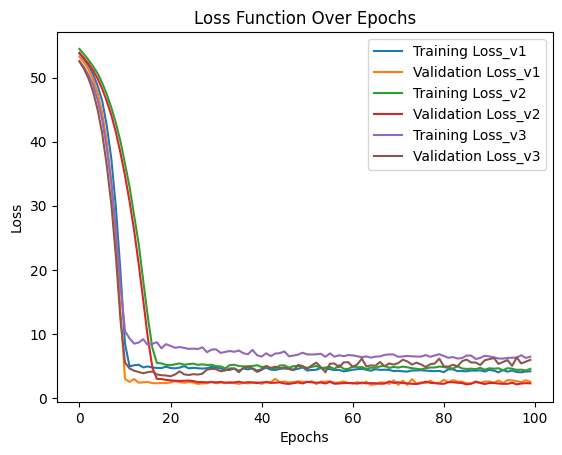

In [14]:
plt.plot(history.history['loss'], label='Training Loss_v1')
plt.plot(history.history['val_loss'], label='Validation Loss_v1')
plt.plot(history2.history['loss'], label='Training Loss_v2')
plt.plot(history2.history['val_loss'], label='Validation Loss_v2')
plt.plot(history3.history['loss'], label='Training Loss_v3')
plt.plot(history3.history['val_loss'], label='Validation Loss_v3')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Function Over Epochs')
plt.legend()
plt.show()

In [25]:
model1 = keras.models.load_model("win_rate_NNv1.keras")
model2 = keras.models.load_model("win_rate_NNv2.keras")
model3 = keras.models.load_model("win_rate_NNv3.keras")

In [ ]:
model1.summary()

In [27]:
model2.summary()

Model: "sequential_25"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_154 (Dense)               │ (None, 64)             │         2,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_155 (Dense)               │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gaussian_dropout_59             │ (None, 128)            │             0 │
│ (GaussianDropout)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_156 (Dense)               │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gaussian_dropout_60             │ (None, 64)             │             0 │
│ (GaussianDropout)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_157 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_158 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 63,941 (249.77 KB)

 Trainable params: 21,313 (83.25 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 42,628 (166.52 KB)

In [28]:
model3.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_6 (Dense)                 │ (None, 64)             │         2,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gaussian_dropout_2              │ (None, 128)            │             0 │
│ (GaussianDropout)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gaussian_dropout_3              │ (None, 32)             │             0 │
│ (GaussianDropout)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 67,109 (262.15 KB)

 Trainable params: 22,369 (87.38 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 44,740 (174.77 KB)